<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-imports-and-dfs" data-toc-modified-id="Load-imports-and-dfs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load imports and dfs</a></span></li><li><span><a href="#Score-log" data-toc-modified-id="Score-log-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Score log</a></span><ul class="toc-item"><li><span><a href="#clean-log" data-toc-modified-id="clean-log-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>clean log</a></span></li></ul></li></ul></div>

In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 120 seconds


1. Load imports & test, train DFs
2. Apply stratified kfold & traing with lgbm and submit to kaggle
3. Check for missing data feature engineering parts missed if score > 3.7
4. Split the training set to train & validation
5. Train over RF to get a benchmark of the dataset
6. Drop irrelevant features by sorting on feature importance
7. Drop redundant features by plotting a Dendogram and removing the redundancy
8. Use a feature interpreter to see which feature is contributing lot to prediction
9. Use extrapolation to see if we can remove feature which add bias of training & validation set
10. Use partial dependence plot to see outliers/missed features
11. Submit to kaggle the RF model and see the score
11. Use stratified kfold to train the RF model and submit to kaggle
12. Repeat again with LGBM/XGBoost/Adaboost. Stack the model and submit to kaggle


### Load imports and dfs

In [27]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings

In [28]:
train_clean = pd.read_csv('train_clean.csv')
test_clean = pd.read_csv('test_clean.csv')

In [29]:
train_df2 = train_clean
test_df2 = test_clean

In [42]:
train_clean0 = feather.read_dataframe('train_clean0')

In [43]:
train_df2 = train_clean0

In [8]:
# for df in [train_df2, test_df2]:
#     for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
#                      'purchase_date_min_old']:
#         df[f] = df[f].astype(np.int64) * 1e-9

In [44]:
df_train_columns = [c for c in train_df2.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df2['target']

In [45]:
target.shape

(201917,)

In [46]:
del train_df2['target']

In [47]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.74254	valid_1's rmse: 3.77622
[200]	training's rmse: 3.68267	valid_1's rmse: 3.7372
[300]	training's rmse: 3.64071	valid_1's rmse: 3.71591
[400]	training's rmse: 3.60901	valid_1's rmse: 3.70287
[500]	training's rmse: 3.58324	valid_1's rmse: 3.69444
[600]	training's rmse: 3.56125	valid_1's rmse: 3.68796
[700]	training's rmse: 3.54321	valid_1's rmse: 3.68318
[800]	training's rmse: 3.52655	valid_1's rmse: 3.67935
[900]	training's rmse: 3.51175	valid_1's rmse: 3.67619
[1000]	training's rmse: 3.49816	valid_1's rmse: 3.67388
[1100]	training's rmse: 3.48523	valid_1's rmse: 3.67196
[1200]	training's rmse: 3.47319	valid_1's rmse: 3.67071
[1300]	training's rmse: 3.46176	valid_1's rmse: 3.66938
[1400]	training's rmse: 3.45081	valid_1's rmse: 3.66841
[1500]	training's rmse: 3.44007	valid_1's rmse: 3.66747
[1600]	training's rmse: 3.42949	valid_1's rmse: 3.66667
[1700]	training's rmse: 3.41949	valid_1's rm

3.6654940704861985

### Score log

1. Score for submission-2019-01-11 10:18:09.909061.csv - 3.6597596743401666, LB - 3.707 (included cat_1)
2. Score for submission-2019-01-12 13:53:27.215115.csv - 3.656726211308068, LB - 3.696 (jst refactored)
3. No changes what so ever - 3.6627995460091523
4. Replaced with kernels code - 3.6623128394907103
5. Replaced with kernels code along with cat_2 mean - 3.6609564684554594

#### clean log
1. pristine - 3.6665896029106544 - LB - (3.695 claimed)  - old params
2. Train clean 0 - filled NaNs with 0 - 3.6650870107813533 - LB - old params
3. Train pristine - 3.667856740589569 - LB - 3.701 - new params
4. Train clean 0 - filled with 0s - 3.6654940704861985 - new params

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


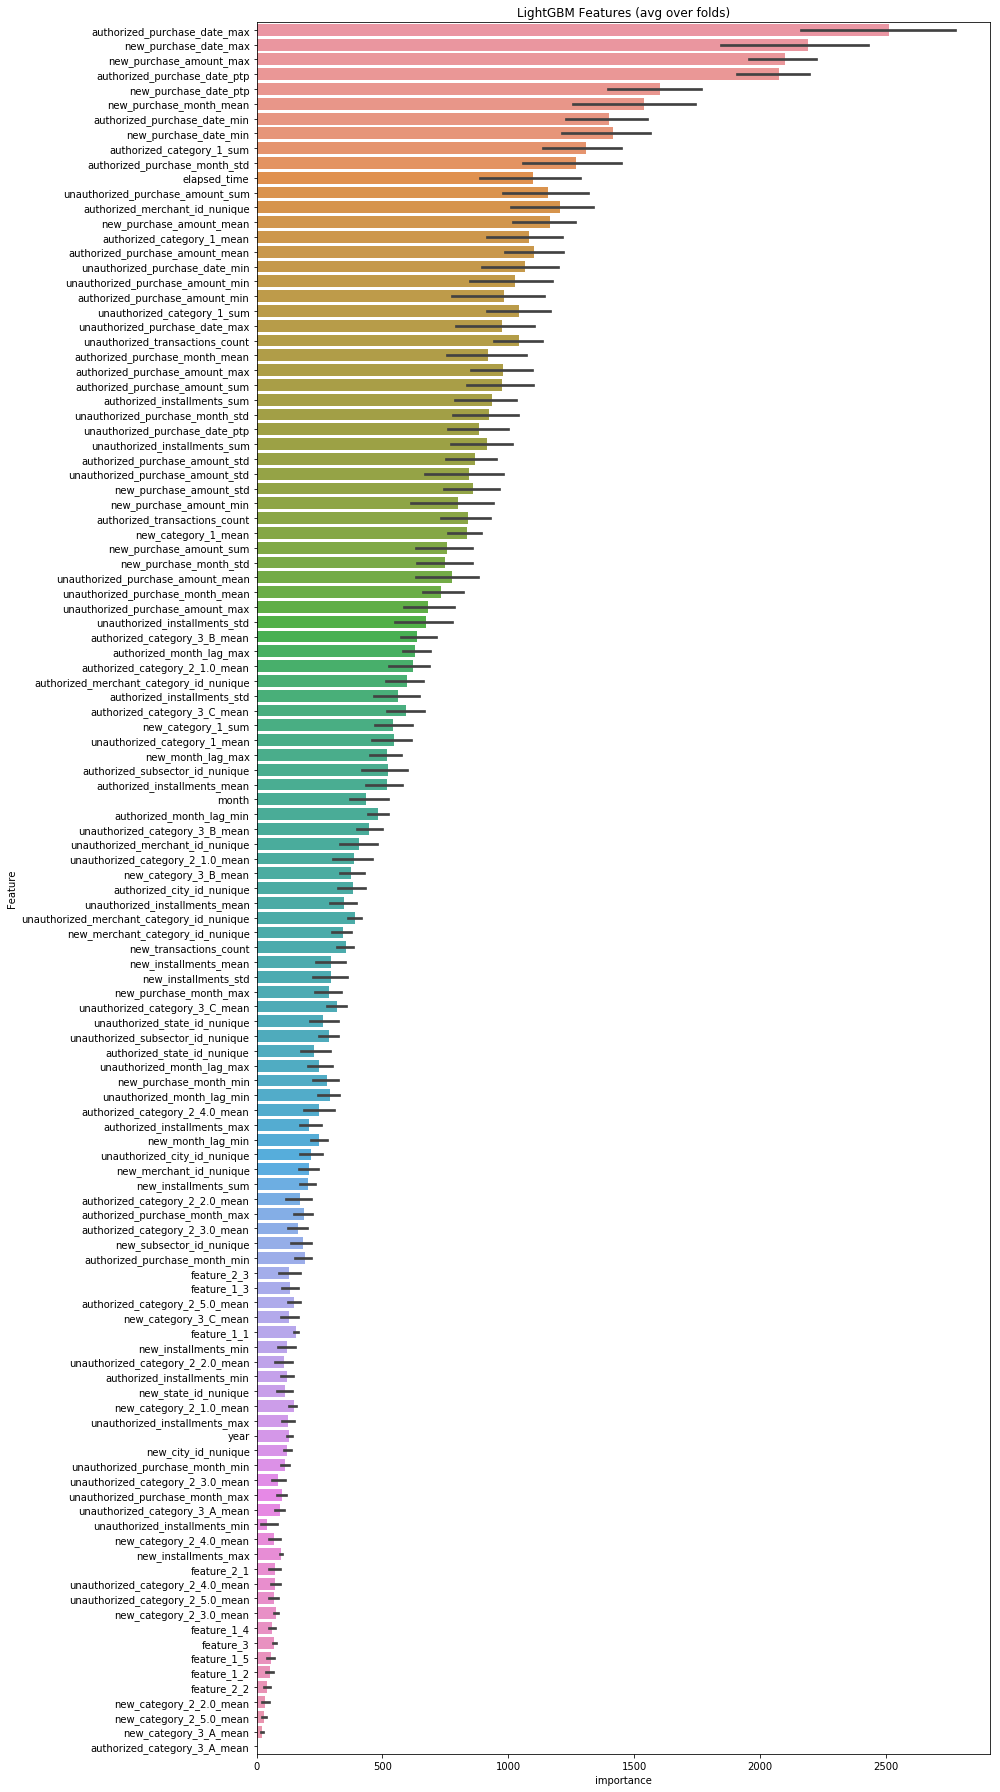

In [38]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [39]:
sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'submission-{pd.to_datetime("today")}.csv', index=False)

In [40]:
!ls

'Elo - ML model clean.ipynb'
'Elo - ML model proc_df.ipynb'
'Elo - ML model-RF copy.ipynb'
'Elo - ML model.ipynb'
'Elo RF.ipynb'
'Elo end 2 end.ipynb'
'Elo feature engineering-proc_df.ipynb'
'Elo feature engineering.ipynb'
'Elo merchant category reco - using RF.ipynb'
 README.md
'Scrap pad.ipynb'
'Scrap pad.py'
'TS Fresh.ipynb'
'TS Fresh.py'
'Train & test clean.ipynb'
 adf
 data
 df_hot_dropped_all
 df_hot_ext
 df_hot_test
 df_hot_test_ext
 df_proc_dfed
 df_test_n_o
 df_xo
 fastai
 hist_trans
 hist_trans_agg
 hist_trans_agg_proc
 lgbm_importances.png
 new_hist_prc
 new_hist_trans
 new_hist_trans_agg
 new_trans_agg_proc
'submission-2019-01-11 09:49:53.716164.csv'
'submission-2019-01-11 10:18:09.909061.csv'
'submission-2019-01-12 13:53:27.215115.csv'
'submission-2019-01-12 16:27:31.239044.csv'
'submission-2019-01-12 17:25:56.678553.csv'
'submission-2019-01-12 17:33:29.475835.csv'
'submission-2019-01-12 17:42:01.350278.csv'
'submission-2019-01-12 22:12:59.947458.csv'
'submission-2019-01-1

In [41]:
FileLink('./submission-2019-01-15 22:29:20.144417.csv')

/home/chandrasekhar/private/kaggle/submission-2019-01-15 22:29:20.144417.csv